In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

import IPython 


In [61]:
bs = 128
epochs = 10

In [62]:
def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

In [63]:
def flatten(x):
    return to_var(x.view(x.size(0), -1))

In [64]:
def save_image(x, path='real_image.png'):
    torchvision.utils.save_image(x, path)

In [121]:
import torch
import os
import numpy as np
import csv
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

from imageio import *
import librosa
import librosa.display
import skimage.io
import matplotlib.pyplot as plt



default_transform = transforms.Compose([
    transforms.ToTensor(),
    ])

class bair_robot_pushing_dataset(Dataset):
    def __init__(self,mode='train', transform=default_transform):
        assert mode == 'train' or mode == 'test' or mode == 'validate'
        #raise NotImplementedError


        self.seed_is_set = False # multi threaded loading
        self.d = 0

        self.root_dir = './data_test'
        self.data_type = 'valve'

        if mode=='train':
            self.data_dir = '%s/train/%s' % (self.root_dir, self.data_type)
            self.ordered = False
        elif mode=='validate':
            self.data_dir = '%s/val/%s' % (self.root_dir, self.data_type)
            self.ordered = True
        else:
            self.data_dir = '%s/test/%s' % (self.root_dir, self.data_type)
            self.ordered = True

        self.dirs = []

        for d1 in os.listdir(self.data_dir):
            for d2 in os.listdir('%s/%s' % (self.data_dir, d1)):
                for d3 in os.listdir('%s/%s/%s' % (self.data_dir, d1, d2)):
                    self.dirs.append('%s/%s/%s/%s' % (self.data_dir, d1, d2, d3))

        # print(self.dirs)

        self.transformations = transform


    def __len__(self):
        # raise NotImplementedError
        # return self.seq_len
        # print(len(self.dirs))
        return len(self.dirs)

    def __getitem__(self, index):
#         print(self.dirs[index])
        y , sr = librosa.load(self.dirs[index], sr=16000)
#         mfccs = librosa.feature.mfcc(y=y, sr=sr)
        M1 = librosa.feature.melspectrogram(y=y, n_fft=512, n_mels=64, sr=sr)        
        M_db1 = librosa.power_to_db(M1, ref=np.max)
#         print(M_db1.shape)

#         fig = plt.figure()
#         plt.axis('off')
#         librosa.display.specshow(M_db1, x_axis='time', y_axis='mel')
#         fig.canvas.draw()
#         img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
#         img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))       
#         img = Image.fromarray(img, mode='RGB').convert('L')
#         img = img.resize((128, 128), Image.ANTIALIAS)

#         img = self.transformations(img)
        M_db1_tensor = self.transformations(M_db1)

        return M_db1_tensor


In [122]:
train_dataset = bair_robot_pushing_dataset( 'train')

In [123]:
data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True)

In [124]:
fixed_x = next(iter(data_loader))
# save_image(fixed_x, 'real_image.png')
# fixed_x = flatten(fixed_x)

# IPython.display.Image('real_image.png')

In [125]:
print(fixed_x.shape)

torch.Size([8, 1, 64, 313])


In [106]:
class VAE(nn.Module):
    def __init__(self, image_size=20032, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(image_size, h_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(h_dim, z_dim*2)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, image_size),
            nn.Sigmoid()
        )
    
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = to_var(torch.randn(*mu.size()))
        z = mu + std * esp
        return z
    
    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = torch.chunk(h, 2, dim=1)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

In [107]:
vae = VAE()
if torch.cuda.is_available():
    vae.cuda()
vae

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=20032, out_features=400, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=400, out_features=40, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=20032, bias=True)
    (3): Sigmoid()
  )
)

In [108]:
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

In [109]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu**2 -  logvar.exp())
    return BCE + KLD

In [110]:
epochs = 100

RuntimeError: reduce failed to synchronize: device-side assert triggered

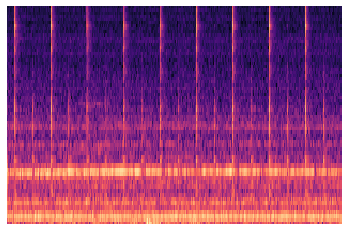

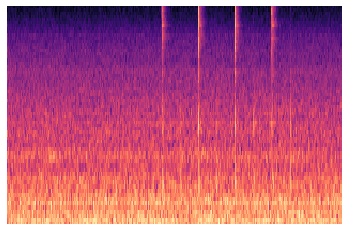

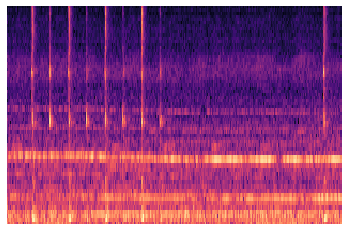

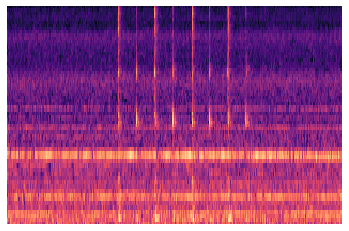

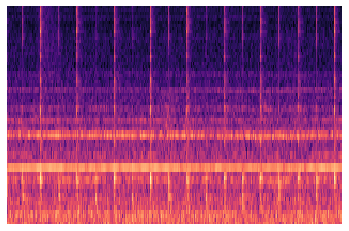

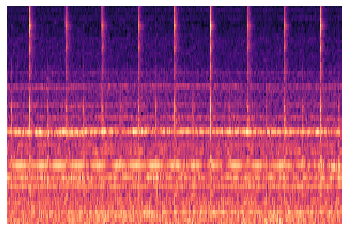

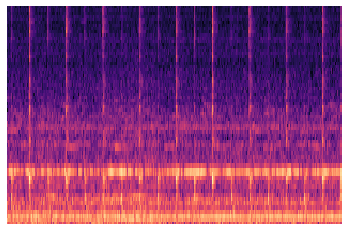

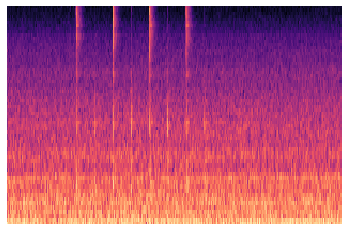

In [112]:
for epoch in range(epochs):
    for idx, images in enumerate(data_loader):
        images = flatten(images)
        recon_images, mu, logvar = vae(images)
        loss = loss_fn(recon_images, images, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if idx%10 == 0:
            print("Epoch[{}/{}] Loss: {:.3f}".format(epoch+1, epochs, loss.item()/bs))
    
            recon_x, _, _ = vae(fixed_x)
            save_image(recon_x.view(recon_x.size(0), 1, 64, 313).data.cpu(), f'reconstructed/recon_image_{epoch}_{idx}.png')
#             save_image(recon_x.view(recon_x.size(0), -1).data.cpu(), f'reconstructed/recon_image_{epoch}_{idx}.png')